In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Catch errors immediately

import torch
torch.cuda.empty_cache()

In [3]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [4]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_euclidean_distance_over_time,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    )

In [5]:
save_dir_path = "./save_directory_noisy_low_samples_2" 


In [6]:
with open("all_dataframes_low_samples.pkl", "rb") as f:
    loaded_dfs_low_samples = pickle.load(f)

# Access them like before:
train_df_low_samples = loaded_dfs_low_samples['train_df_low_samples']
val_df_low_samples = loaded_dfs_low_samples['val_df_low_samples']
test_df_low_samples = loaded_dfs_low_samples['test_df_low_samples']

train_id_df_low_samples = loaded_dfs_low_samples['train_id_df_low_samples']
val_id_df_low_samples = loaded_dfs_low_samples['val_id_df_low_samples']
test_id_df_low_samples = loaded_dfs_low_samples['test_id_df_low_samples']

with open("df_high_energy_low_samples.pkl", "rb") as f:
    df_high_energy_low_samples = pickle.load(f)

val_df_high_energy_low_samples = df_high_energy_low_samples['val_df_high_energy_low_samples']
val_id_df_high_energy_low_samples = df_high_energy_low_samples['val_id_df_high_energy_low_samples']

test_df_high_energy_low_samples = df_high_energy_low_samples['test_df_high_energy_low_samples']
test_id_df_high_energy_low_samples = df_high_energy_low_samples['test_id_df_high_energy_low_samples']

In [7]:
train_id_df_low_samples_added = add_phi_A_columns(train_id_df_low_samples)
val_id_df_low_samples_added = add_phi_A_columns(val_id_df_low_samples)
val_id_df_high_energy_low_samples_added = add_phi_A_columns(val_id_df_high_energy_low_samples)


📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 317 with the value: 0.5512, the losses of the last 5 epochs are: ['0.5765', '0.5679', '0.5997', '0.5913', '0.5539']
  Lowest loss of metric 'val_variance_loss_high_energy' recorded in epoch 318 with the value: 0.8937, the losses of the last 5 epochs are: ['1.2994', '1.0433', '1.0396', '0.9962', '1.0055']
  Lowest loss of metric 'val_prediction_loss_high_energy' recorded in epoch 326 with the value: 0.7062, the losses of the last 5 epochs are: ['0.7423', '0.7062', '0.7119', '0.7154', '0.7186']
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 319 with the value: 0.2617, the losses of the last 5 epochs are: ['0.2659', '0.2683', '0.2710', '0.2793', '0.2782']
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 325 with the value: 0.5337, the losses of the last 5 epochs are: ['0.5337', '0.5404', '0.5542', '0.5514', '0.5358']
  Lowest loss of metric 'val_var

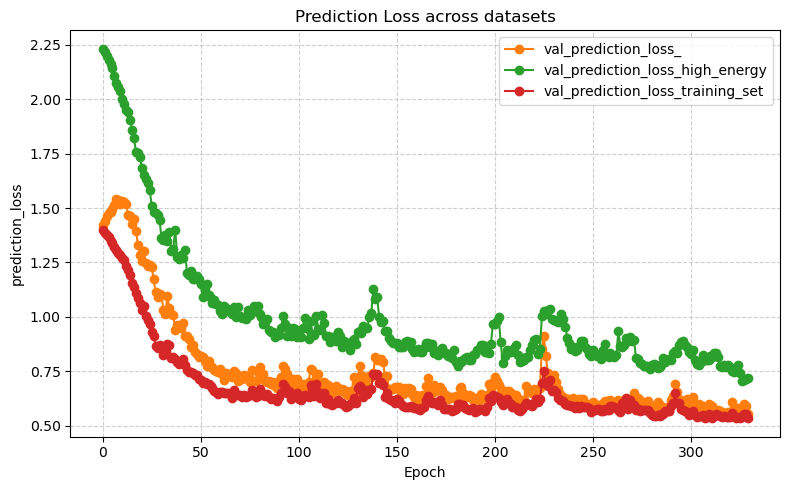

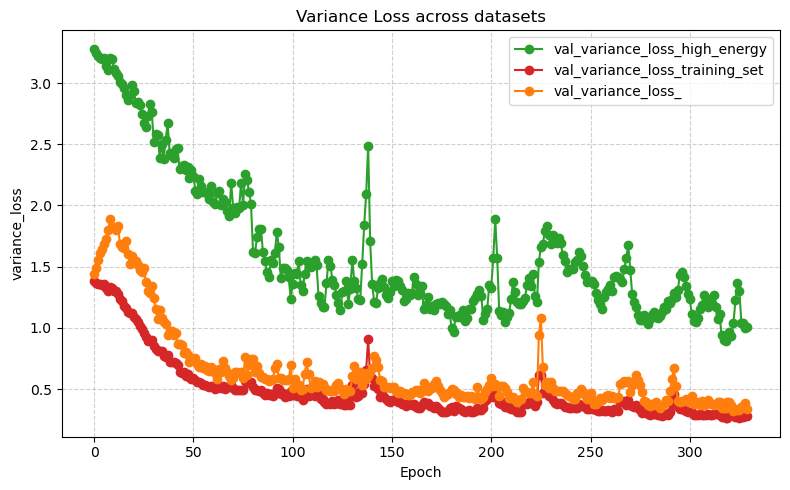

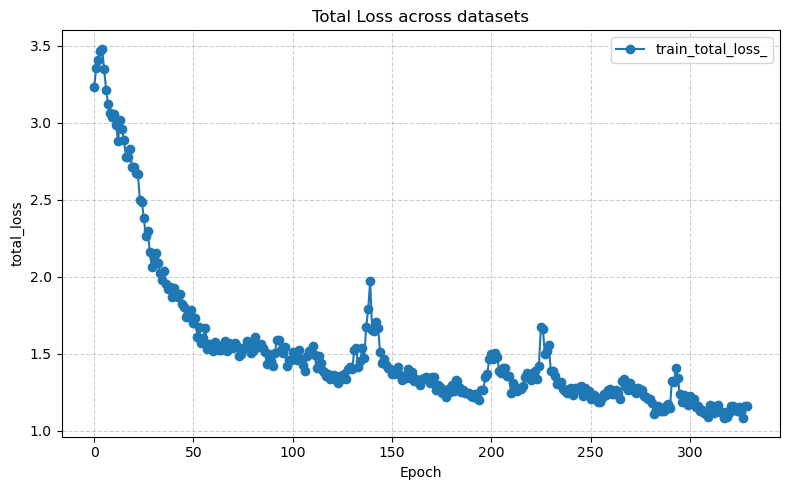

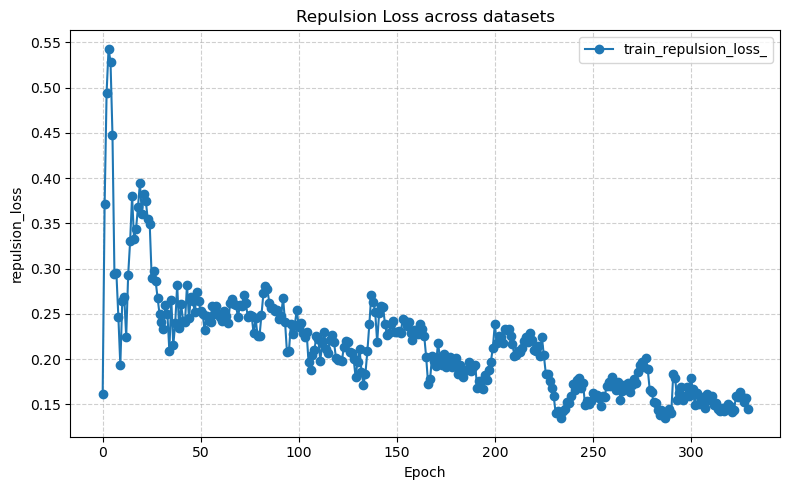

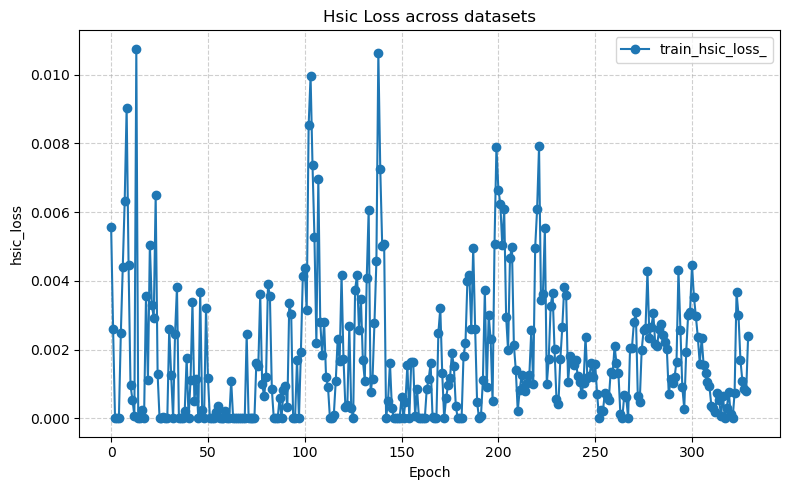

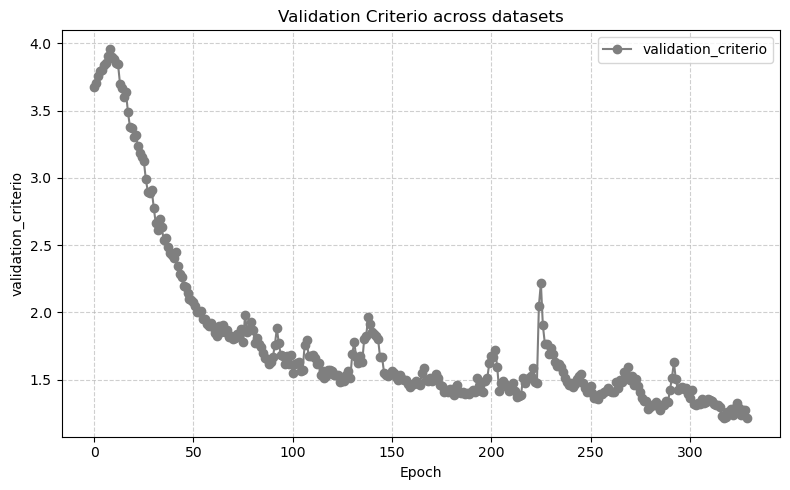

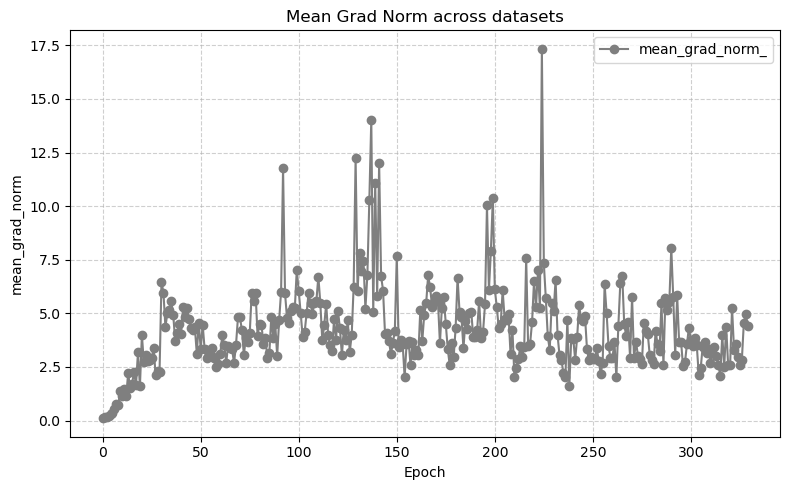

In [163]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_high_energy", "val_prediction_loss_high_energy", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=None
)




📊 Processing directory: val_trajectories_data

For the epoch_329 in val_trajectories_data the values are:
58: X_mean = 0.3428 ± 0.3881, U_mean = -2.7993 ± 0.4439 and A=1.2861003281447578, phi=3.10971502940812
60: X_mean = 0.4349 ± 0.4090, U_mean = -0.0502 ± 0.3459 and A=1.302803629599372, phi=0.3584896193449746
31: X_mean = -0.5409 ± 0.5109, U_mean = -1.0404 ± 0.4066 and A=1.034538675096427, phi=-1.0225411941027112

📊 Processing directory: val_train_set_trajectories_data

For the epoch_329 in val_train_set_trajectories_data the values are:
26: X_mean = 0.1232 ± 0.3028, U_mean = -0.3469 ± 0.3130 and A=0.9808986503009178, phi=-0.10350682800806513
51: X_mean = -0.6439 ± 0.3051, U_mean = -0.9406 ± 0.4140 and A=1.225847748581651, phi=-0.9160542480716283
20: X_mean = -0.4566 ± 0.2698, U_mean = -2.1004 ± 0.5194 and A=0.9123773519944653, phi=-1.9937946817401142

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_329 in val_high_energy_trajectories_data the values are:
5:

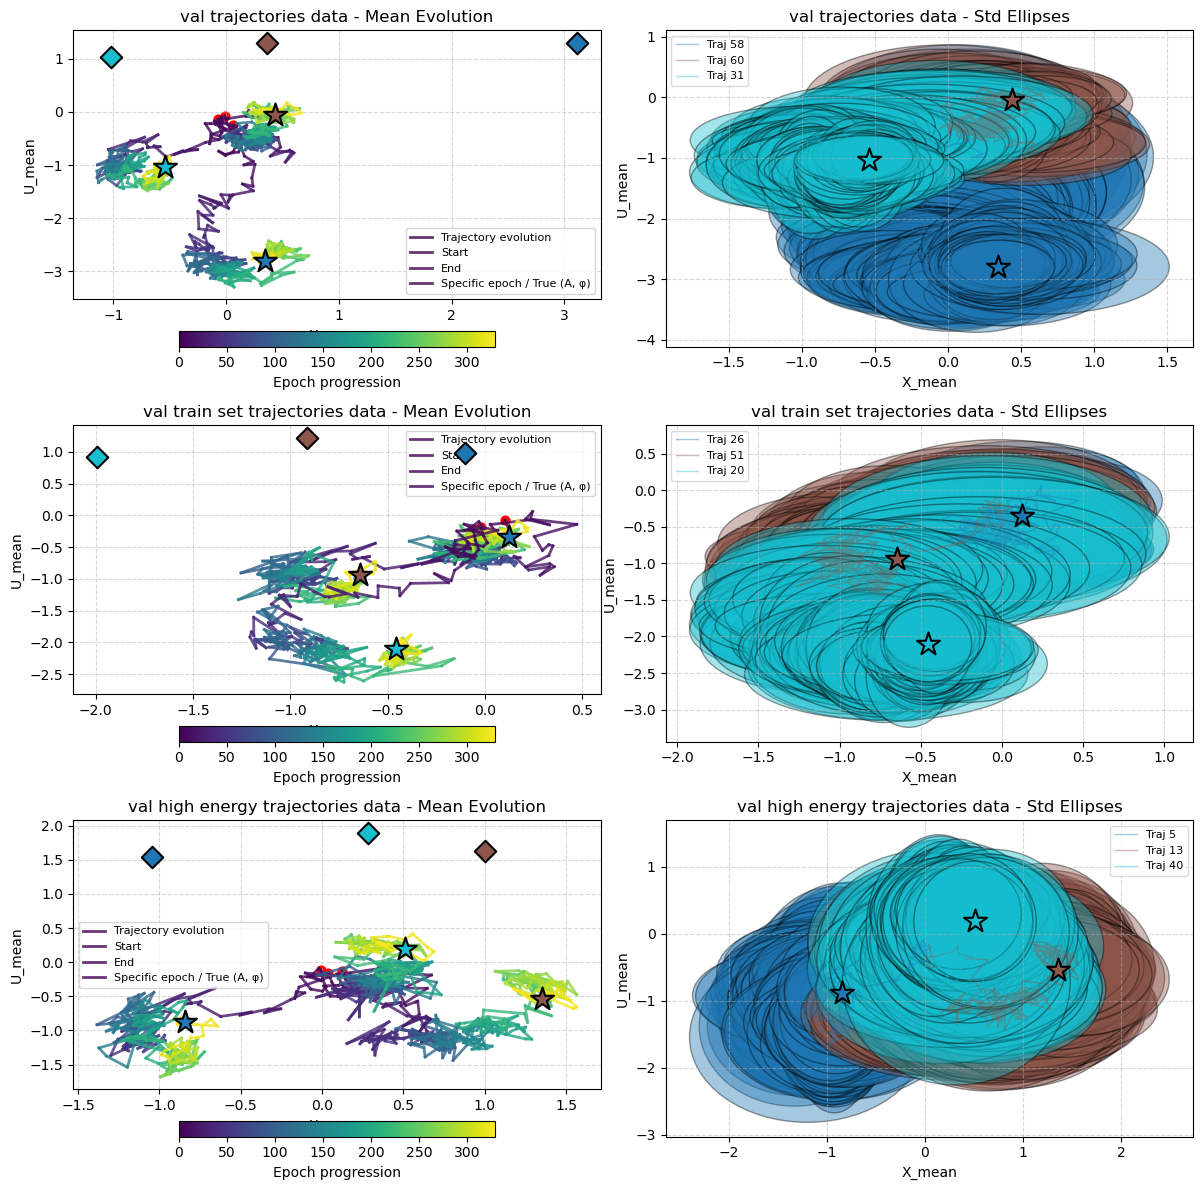


✅ Mean + Std (ellipse) visualization complete.


In [164]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_low_samples_added,val_id_df_added=val_id_df_low_samples_added,val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added)

In [165]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_low_samples_added,
    val_id_df_added=val_id_df_low_samples_added,
    val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added
)

📂 Using data from epoch: epoch_329
✅ Data extraction complete.


In [166]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['A']),
    y=torch.Tensor(val_train_differencies_set_df['phi']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0025)

In [167]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

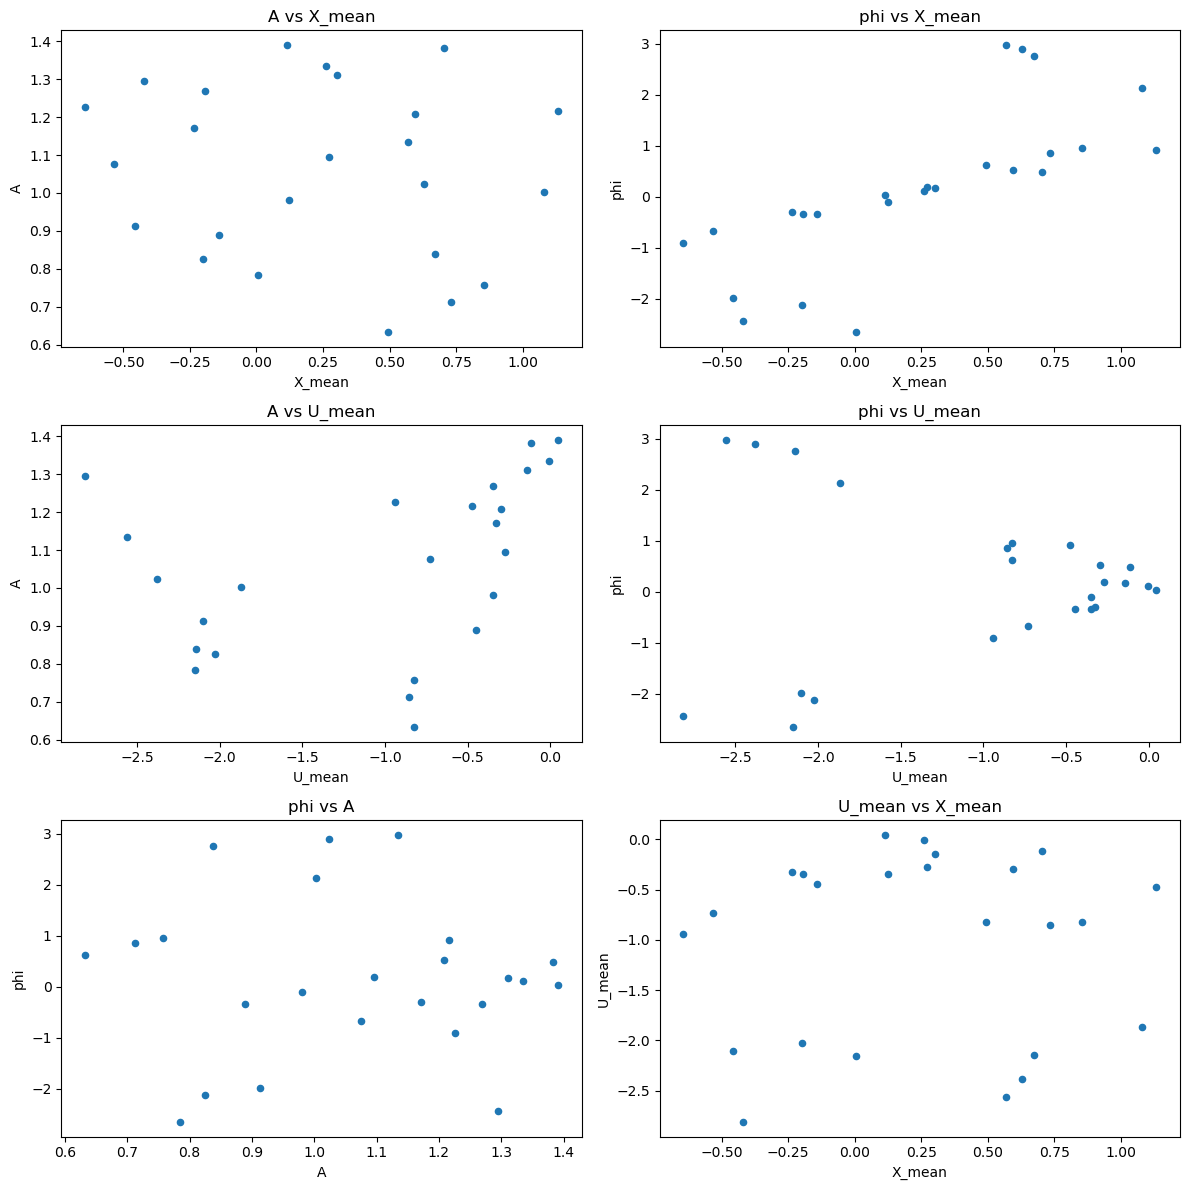

In [168]:
plot_differencies(val_train_differencies_set_df)

📊 Analyzing 330 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


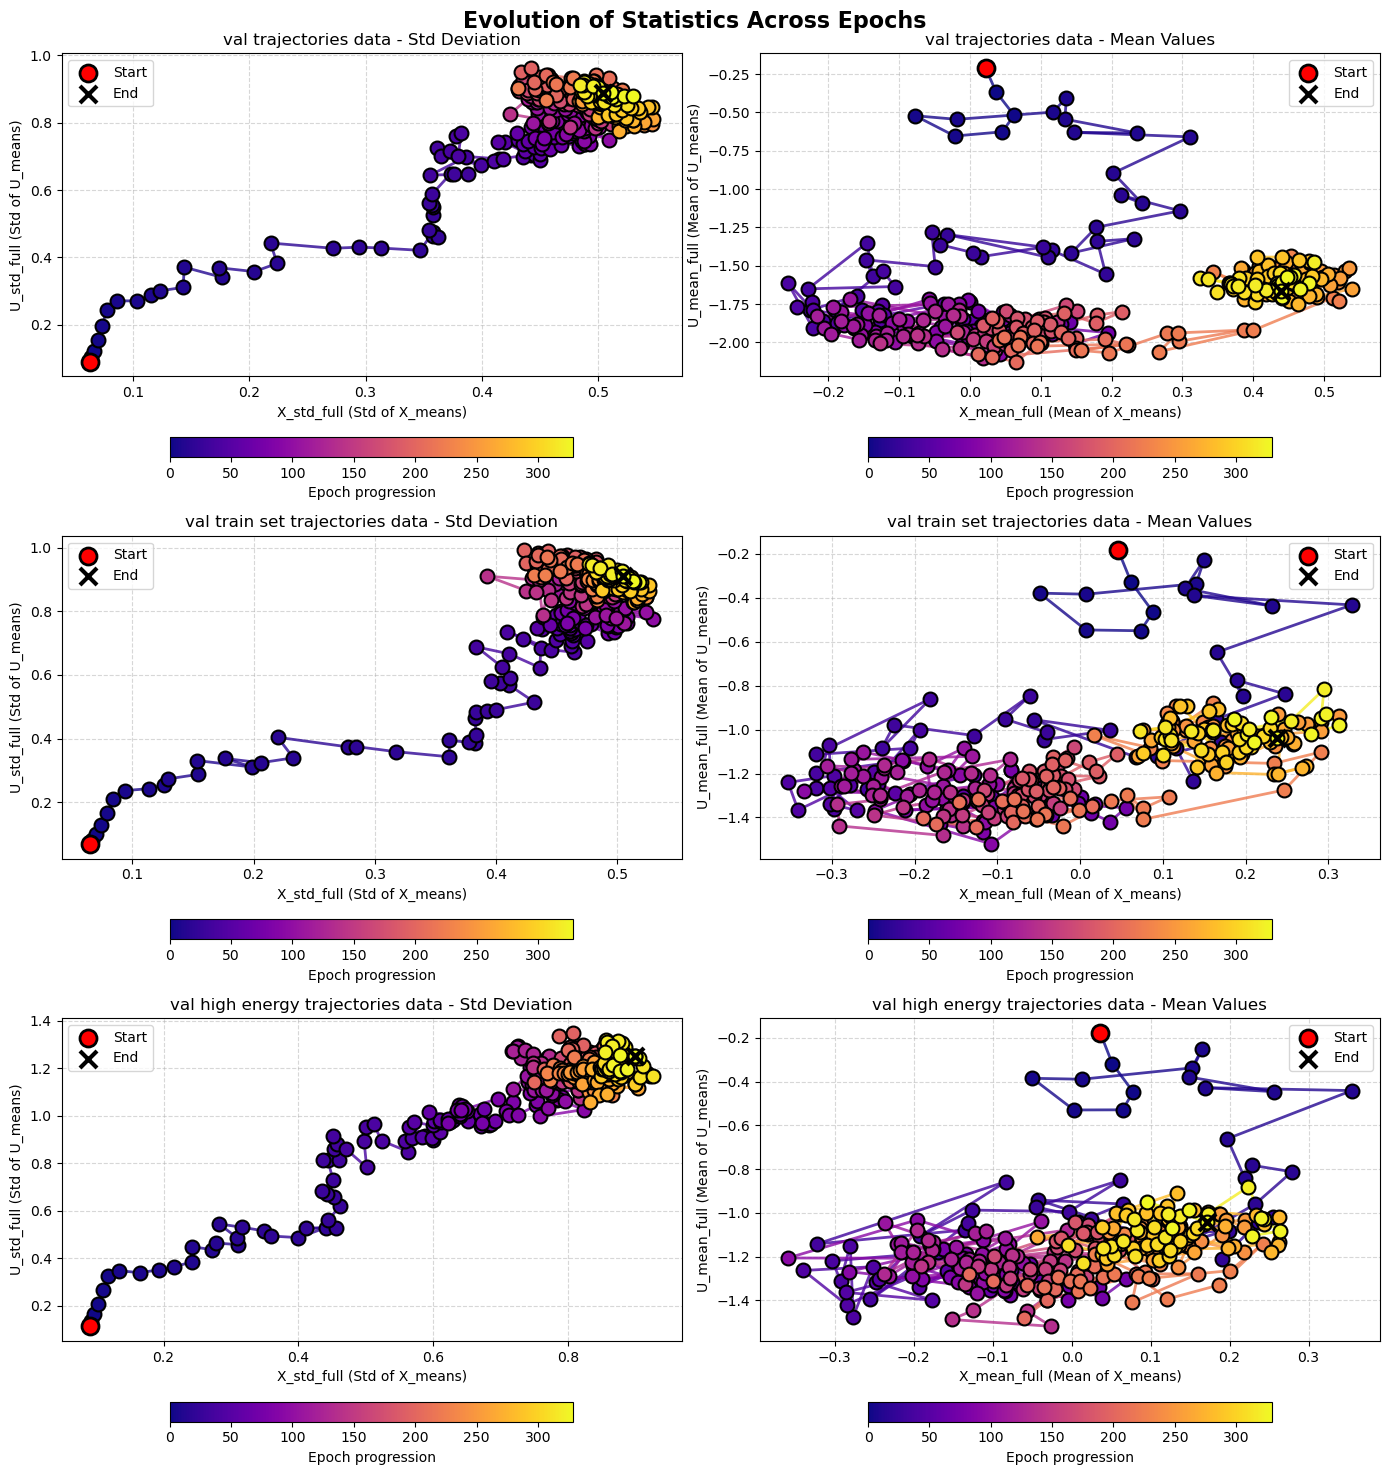

In [169]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [8]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:4082: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [171]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=57, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 3.58e-07
For the inverse network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 5.96e-07


In [9]:
count_parameters(mapping_net)

82560

   num_observed_points  mean_loss
0                    1   0.193939
1                    2   0.184357
2                    3   0.175457
3                    4   0.175581
4                    5   0.171646
5                    6   0.168036
6                    7   0.162181
7                    8   0.157916
8                    9   0.135512
9                   10   0.132751


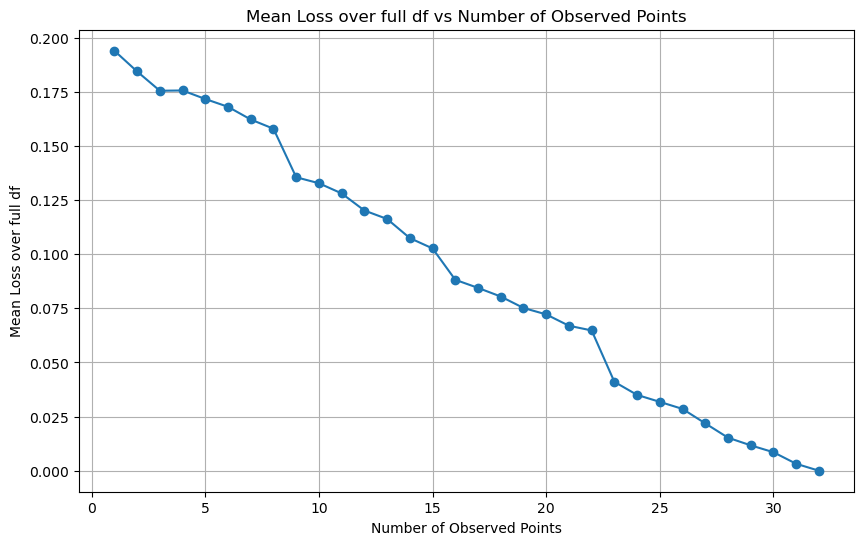

In [42]:
val_loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.025624
2                    3       0.018581
3                    4       0.016844
4                    5       0.014792
5                    6       0.072059
6                    7       0.063626
7                    8       0.056368
8                    9       0.050797
9                   10       0.054937


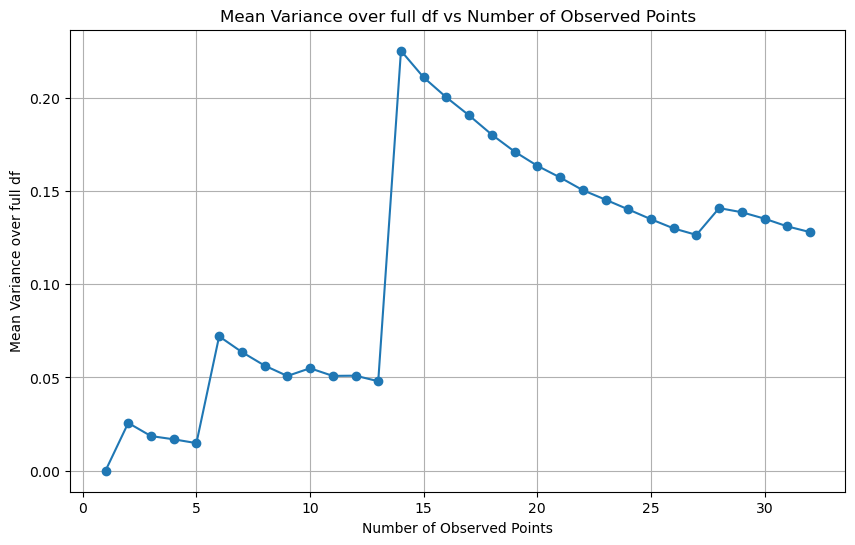

In [11]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net ,device=device)

In [10]:
point_indexes_observed = [0, 5, 10]

In [11]:
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  0.210811         0.241177              0.525278
3               3  0.232432         0.185280              0.384309
4               4  0.243243         0.199252              0.404001
7               7  0.275676         0.239837              0.456791
11             11  0.318919         0.191809              0.339648
16             16  0.372973         0.203723              0.333582
19             19  0.405405         0.222216              0.349004
22             22  0.437838         0.415128              0.627372
23             23  0.448649         0.176602              0.263659
27             27  0.491892         0.205806              0.293443
31             31  0.535135         0.374457              0.511883
32             32  0.545946         0.253458              0.343030
34             34  0.567568         0.359846              0.477647
38             38  0.610811         0.156728              0.20

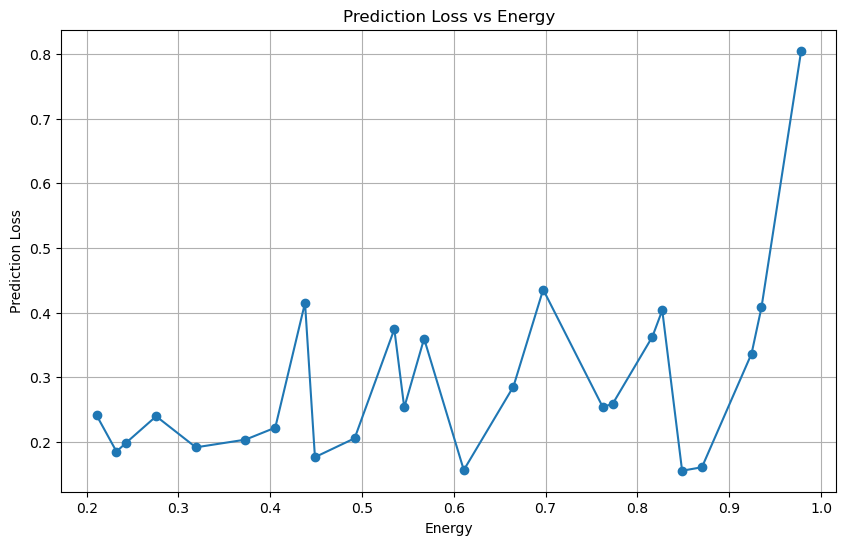

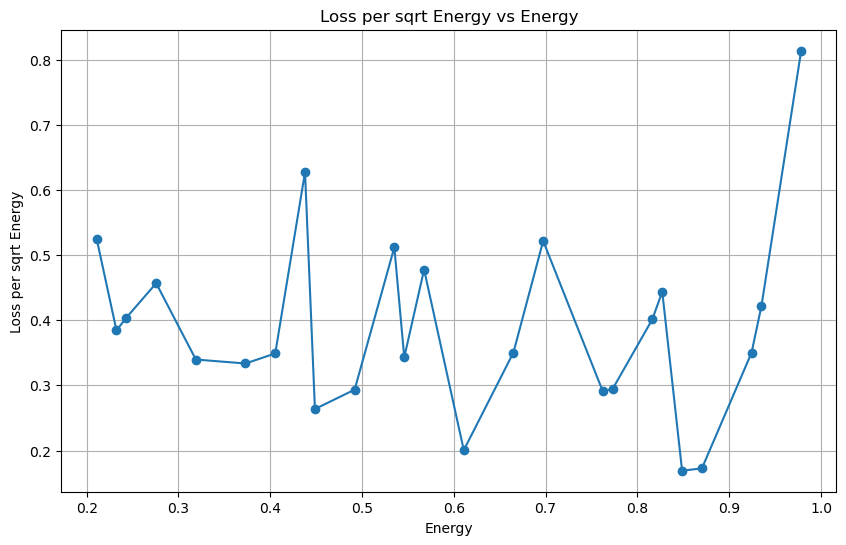

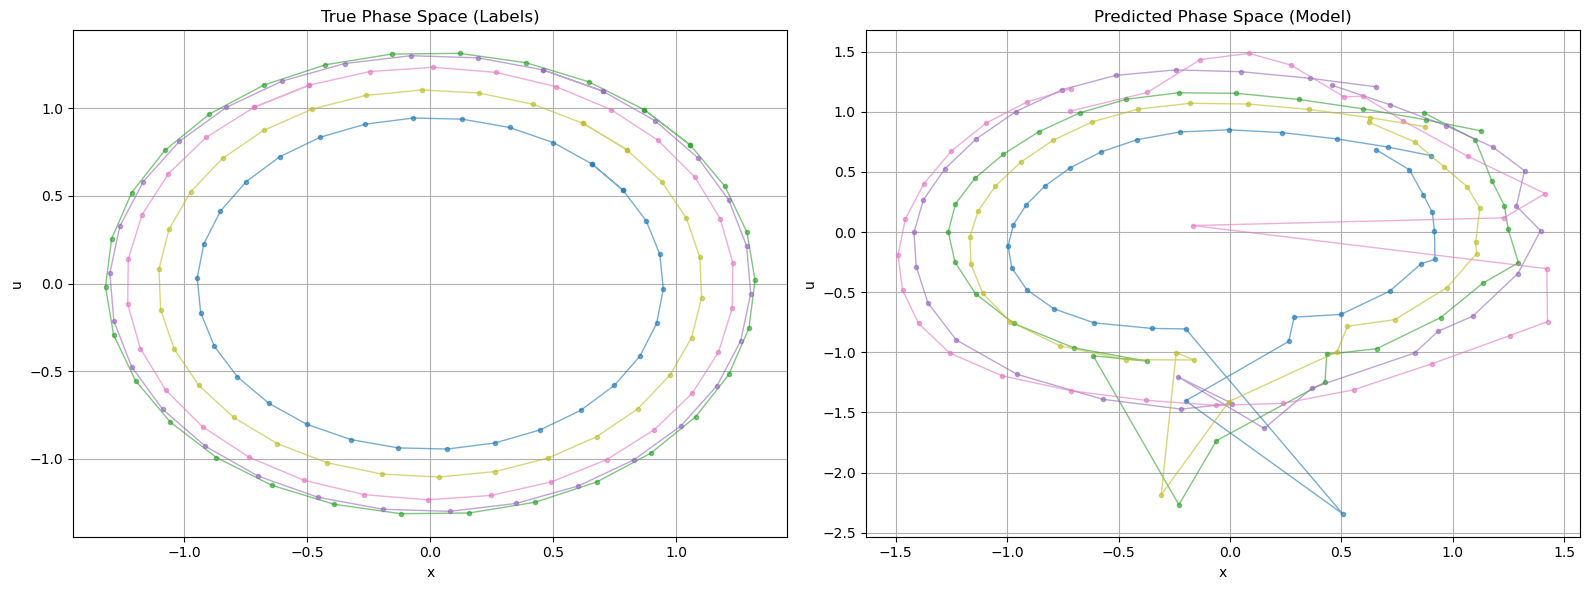

In [21]:
prediction_val_df, mean_prediction_loss_val, pred_val_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=True, plot_trajectories_subsample=0.2)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
1               1  0.210811       0.071353                  0.155405
3               3  0.232432       0.058929                  0.122230
4               4  0.243243       0.058144                  0.117893
7               7  0.275676       0.034689                  0.066068
11             11  0.318919       0.015782                  0.027946
16             16  0.372973       0.059324                  0.097139
19             19  0.405405       0.035682                  0.056041
22             22  0.437838       0.124234                  0.187752
23             23  0.448649       0.060704                  0.090628
27             27  0.491892       0.064157                  0.091476
31             31  0.535135       0.063051                  0.086191
32             32  0.545946       0.079401                  0.107461
34             34  0.567568       0.060201                  0.079909
38             38  0.610811       

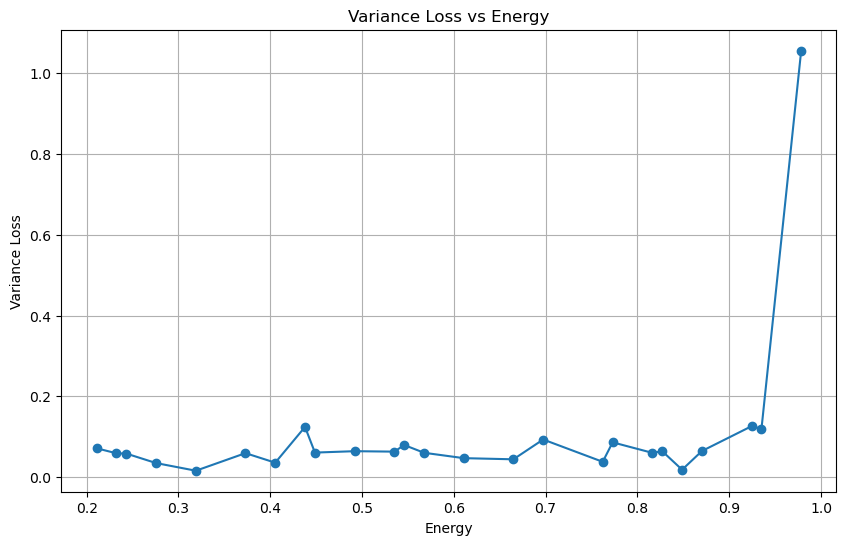

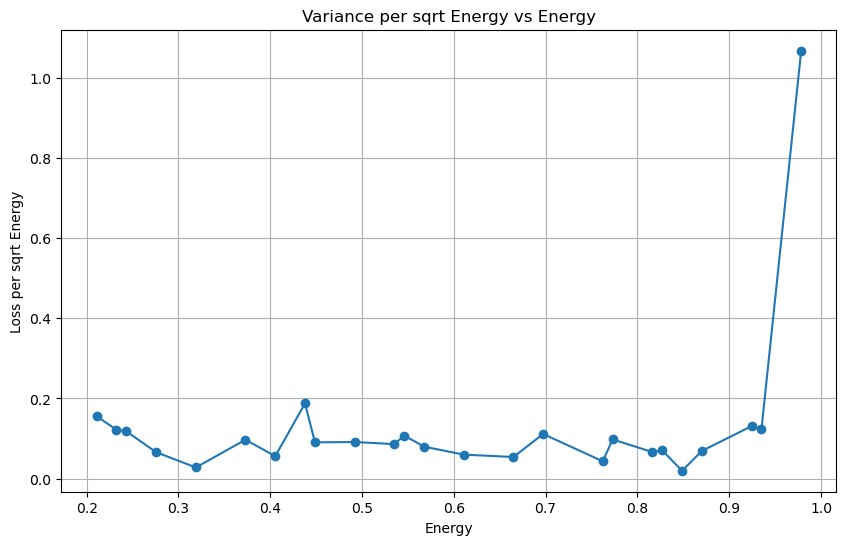

In [19]:
variance_val_df, mean_variance_loss_val = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


Observed time points: [0.        1.0471976 2.0943952]


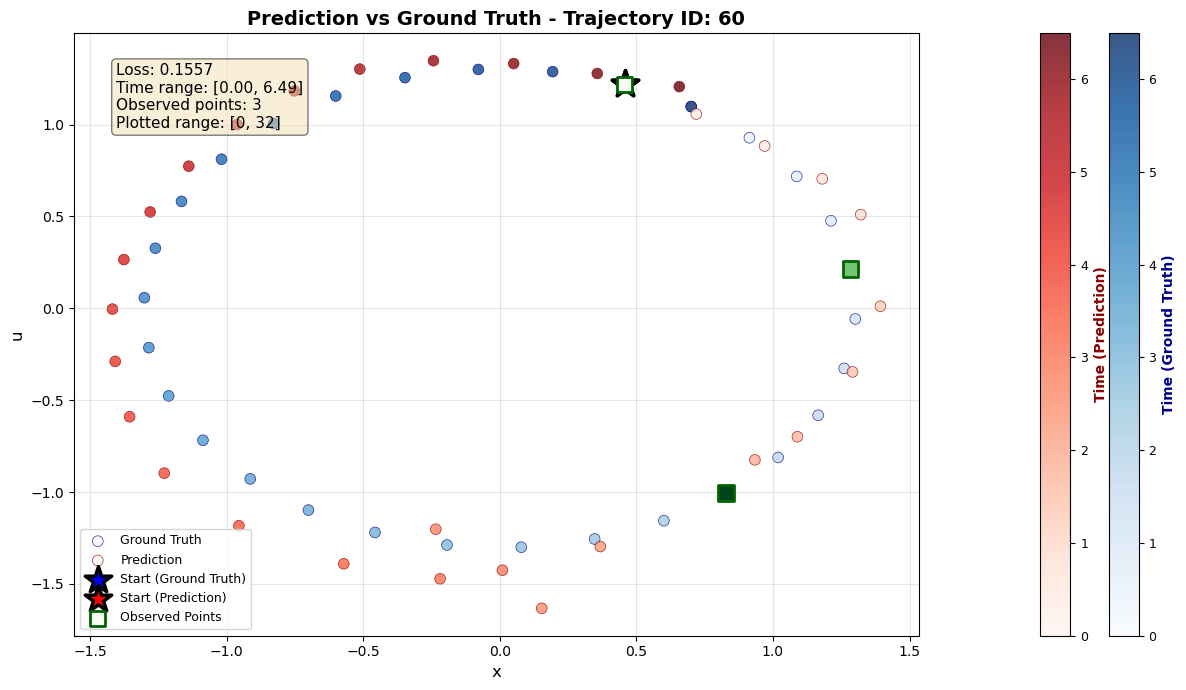

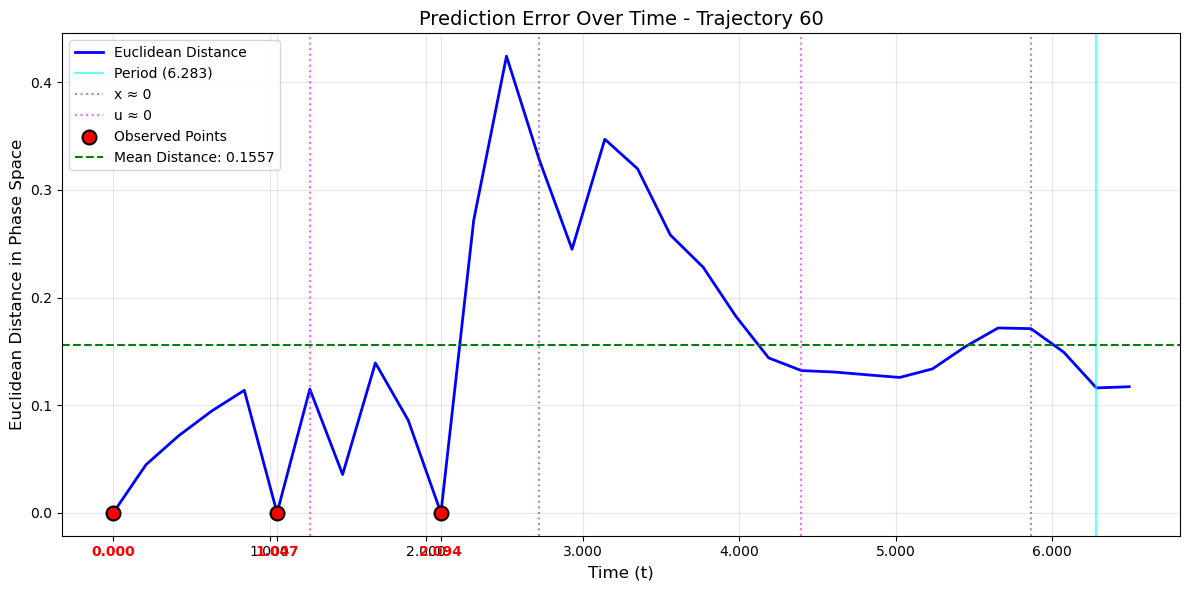

In [12]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=60, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  0.221622         0.303270              0.644205
6               6  0.264865         0.170748              0.331775
9               9  0.297297         0.200738              0.368159
12             12  0.329730         0.182273              0.317427
15             15  0.362162         0.382626              0.635803
17             17  0.383784         0.471220              0.760643
21             21  0.427027         0.390811              0.598052
24             24  0.459459         0.548113              0.808624
25             25  0.470270         0.228365              0.333009
29             29  0.513514         0.187229              0.261275
33             33  0.556757         0.169536              0.227210
36             36  0.589189         0.167160              0.217774
39             39  0.621622         0.210145              0.266536
40             40  0.632432         0.214243              0.26

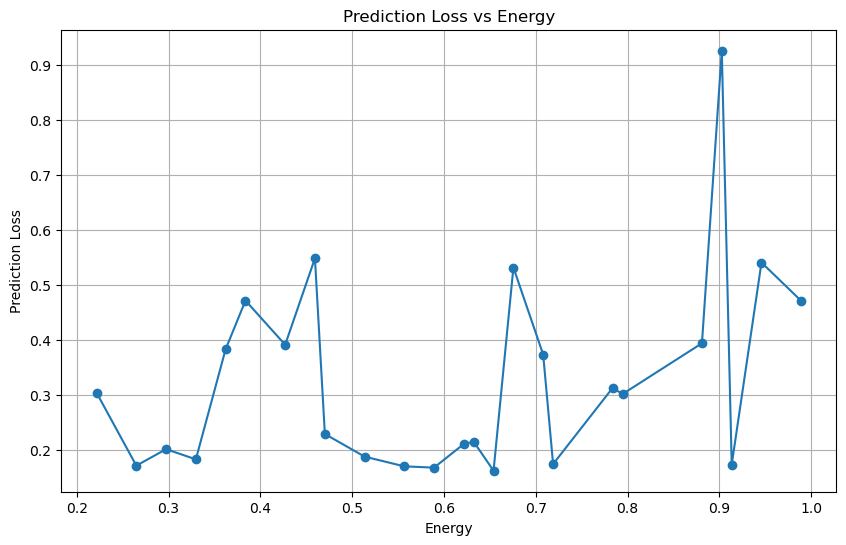

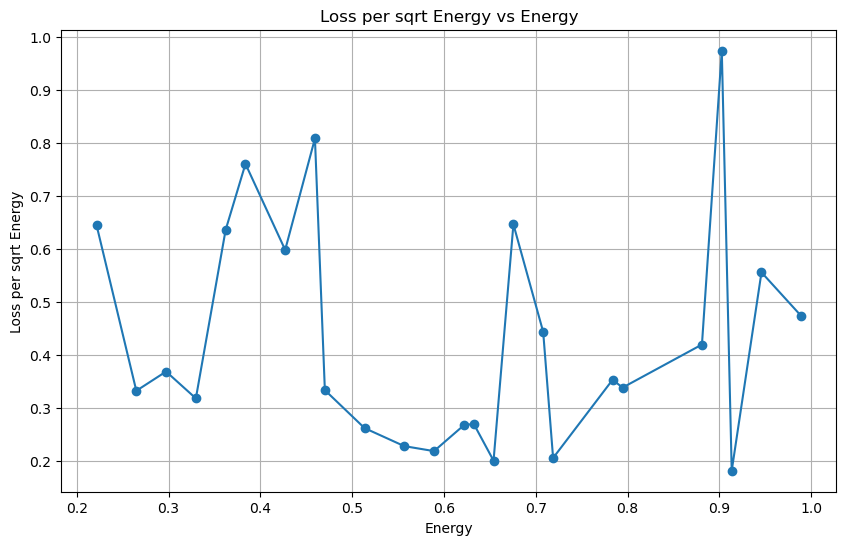

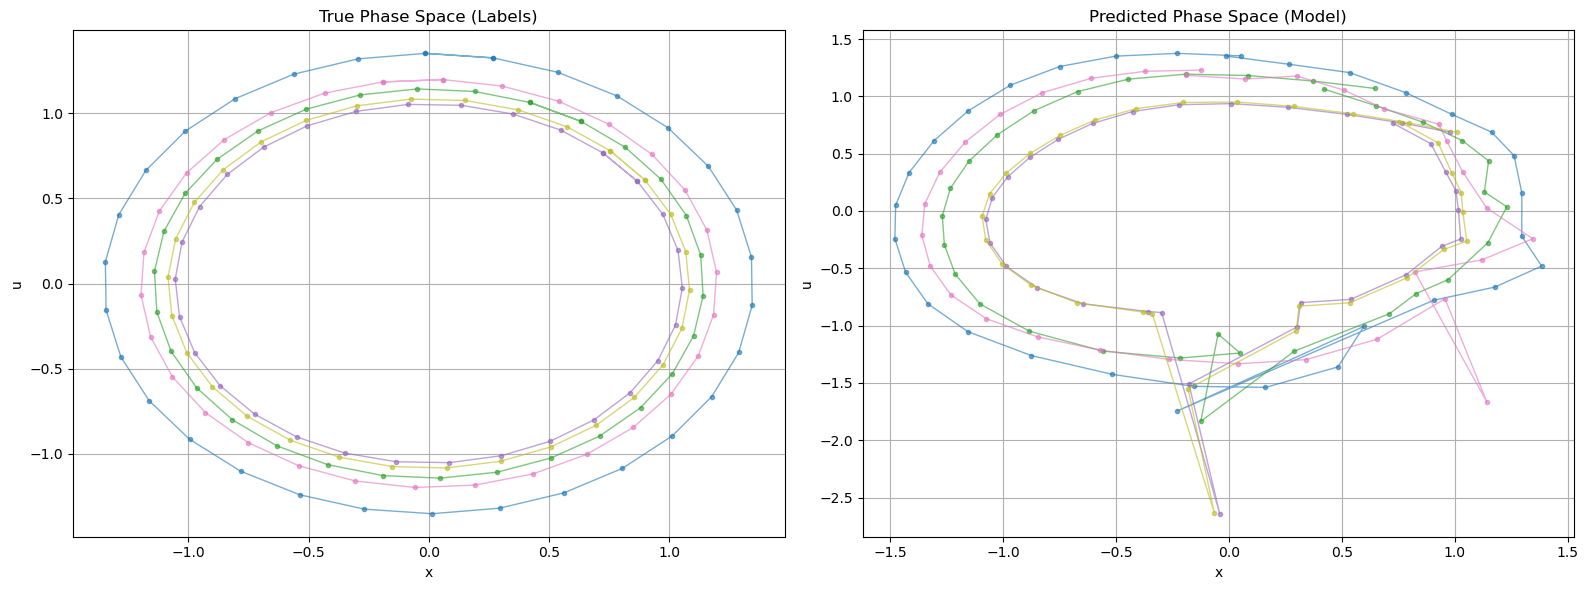

In [22]:
prediction_test_df, mean_prediction_loss_test, pred_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=True, plot_trajectories_subsample=0.2)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
2               2  0.221622       0.061412                  0.130452
6               6  0.264865       0.060168                  0.116910
9               9  0.297297       0.064862                  0.118959
12             12  0.329730       0.061978                  0.107934
15             15  0.362162       0.099939                  0.166067
17             17  0.383784       0.168247                  0.271583
21             21  0.427027       0.110008                  0.168343
24             24  0.459459       0.240987                  0.355525
25             25  0.470270       0.036312                  0.052951
29             29  0.513514       0.006079                  0.008483
33             33  0.556757       0.072207                  0.096771
36             36  0.589189       0.076890                  0.100170
39             39  0.621622       0.110264                  0.139853
40             40  0.632432       

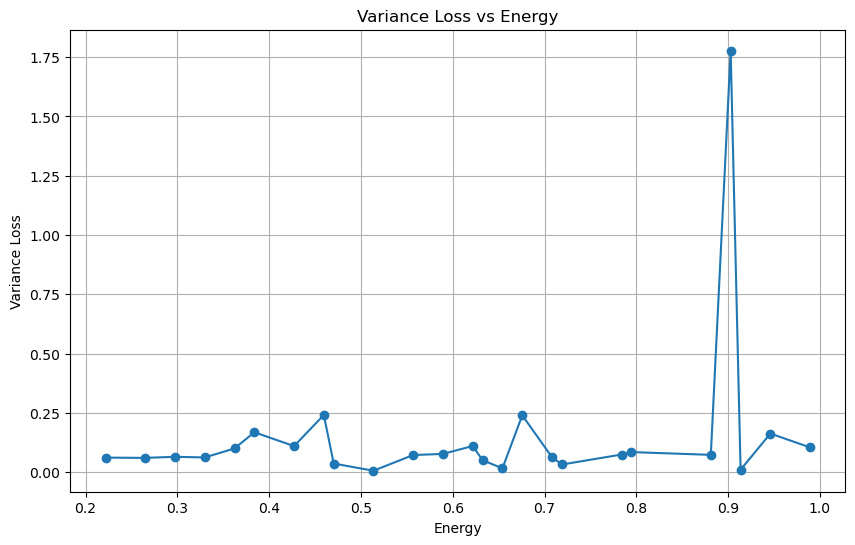

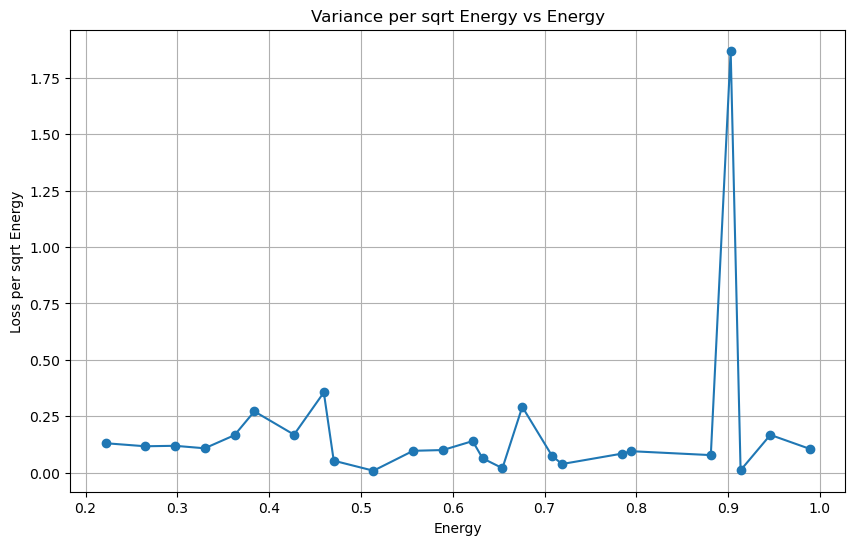

In [23]:
variance_test_df, mean_variance_loss_test = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


Observed time points: [0.        1.0471976 2.0943952]


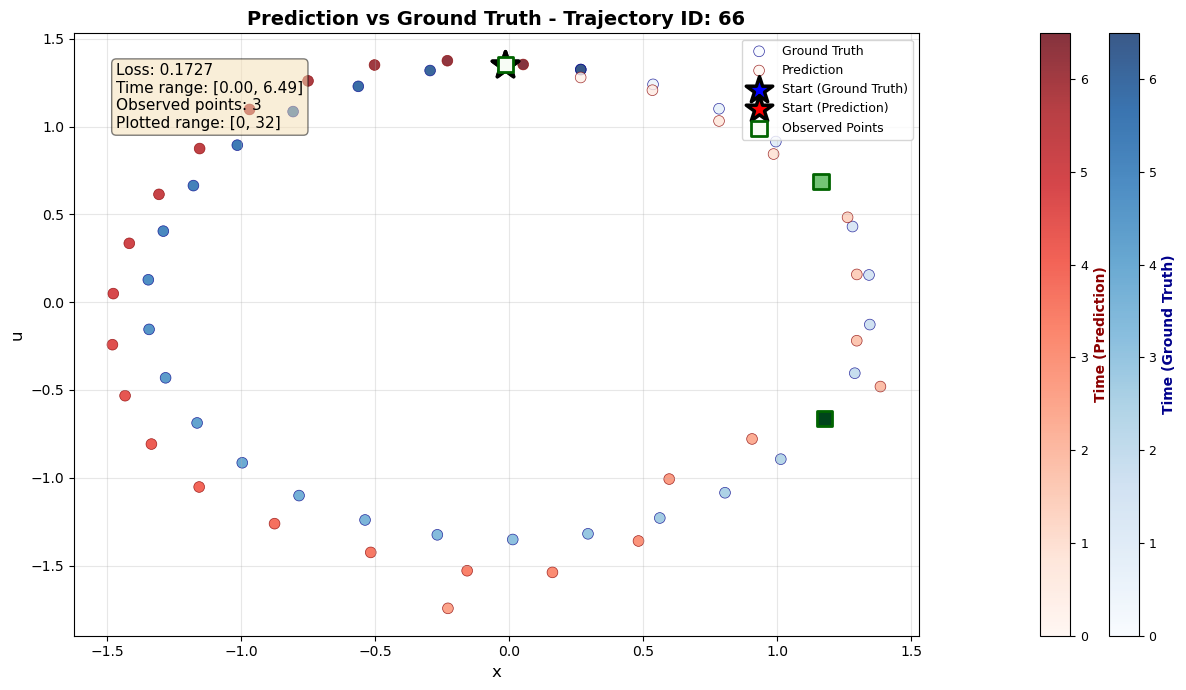

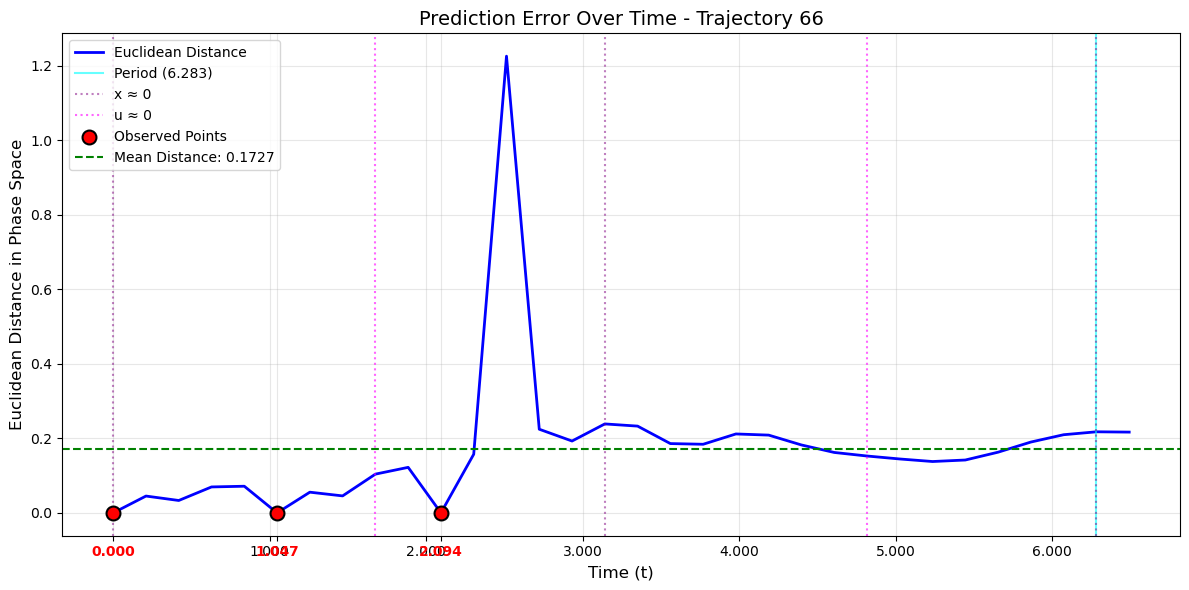

In [13]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, trajectory_id=66, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period)

In [15]:
point_indexes_observed_high_energy = [0,10]

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  1.117551         0.213505              0.201964
2               2  1.135102         1.539387              1.444875
4               4  1.170204         0.181328              0.167623
6               6  1.205306         1.300573              1.184639
7               7  1.222857         0.321348              0.290595
12             12  1.310612         1.377699              1.203420
14             14  1.345714         1.211275              1.044159
15             15  1.363265         0.566903              0.485533
17             17  1.398367         0.205432              0.173723
19             19  1.433469         1.490584              1.244980
20             20  1.451020         0.702371              0.583082
21             21  1.468571         1.459490              1.204352
23             23  1.503673         1.719866              1.402548
24             24  1.521224         0.963078              0.78

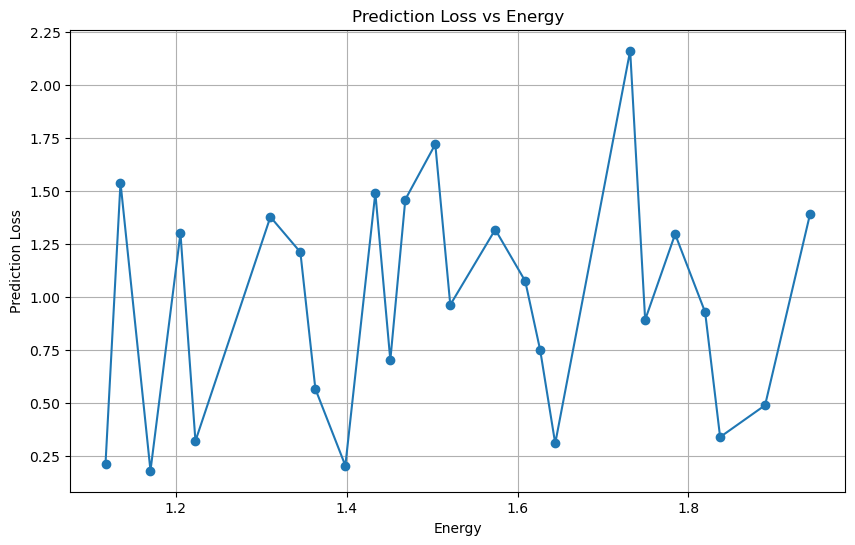

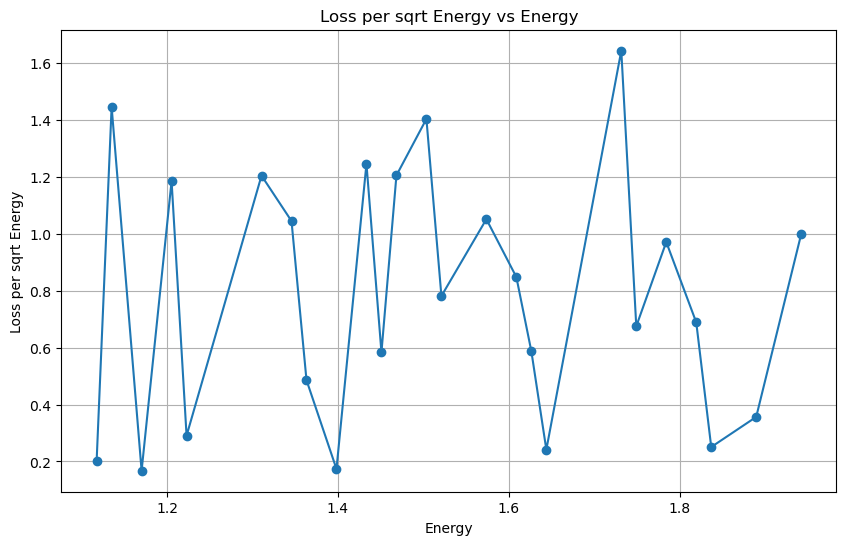

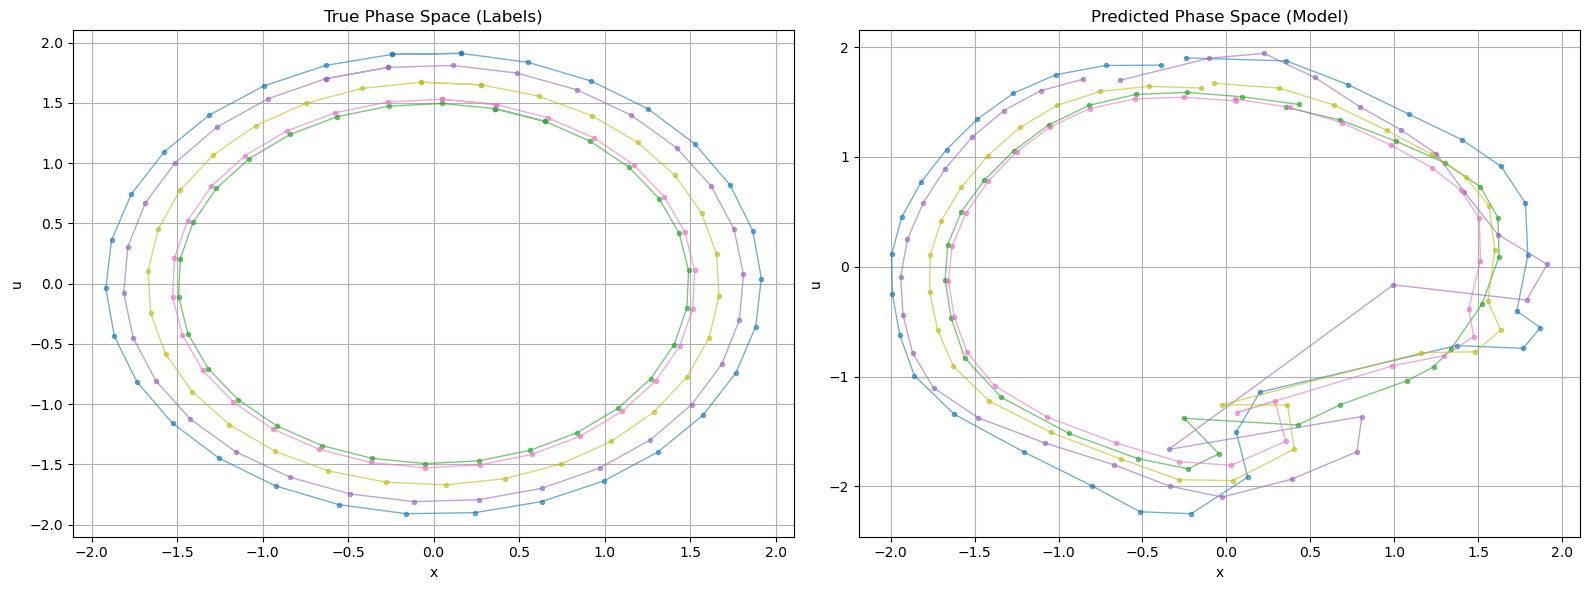

In [37]:
prediction_test_high_energy_df, mean_prediction_loss_test_high_energy, pred_test_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=True, plot_trajectories_subsample=0.2)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
1               1  1.117551       0.003385                  0.003202
2               2  1.135102       4.067237                  3.817526
4               4  1.170204       0.007124                  0.006586
6               6  1.205306       1.919930                  1.748786
7               7  1.222857       0.076620                  0.069288
12             12  1.310612       2.250112                  1.965473
14             14  1.345714       0.573970                  0.494781
15             15  1.363265       0.092042                  0.078831
17             17  1.398367       0.021570                  0.018241
19             19  1.433469       1.223793                  1.022148
20             20  1.451020       0.113080                  0.093875
21             21  1.468571       2.251273                  1.857722
23             23  1.503673       2.422755                  1.975753
24             24  1.521224       

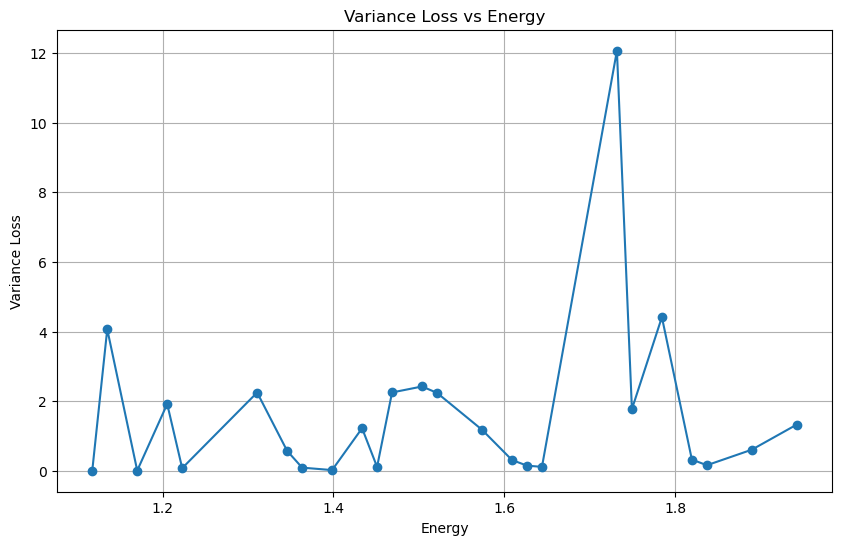

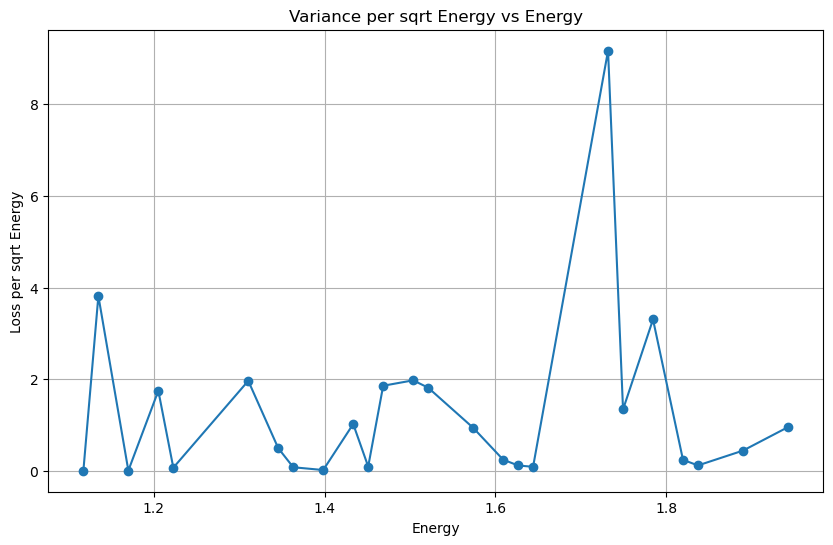

In [38]:
variance_test_high_energy_df, mean_variance_loss_test_high_energy = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed_high_energy)


Observed time points: [0.        2.0943952]


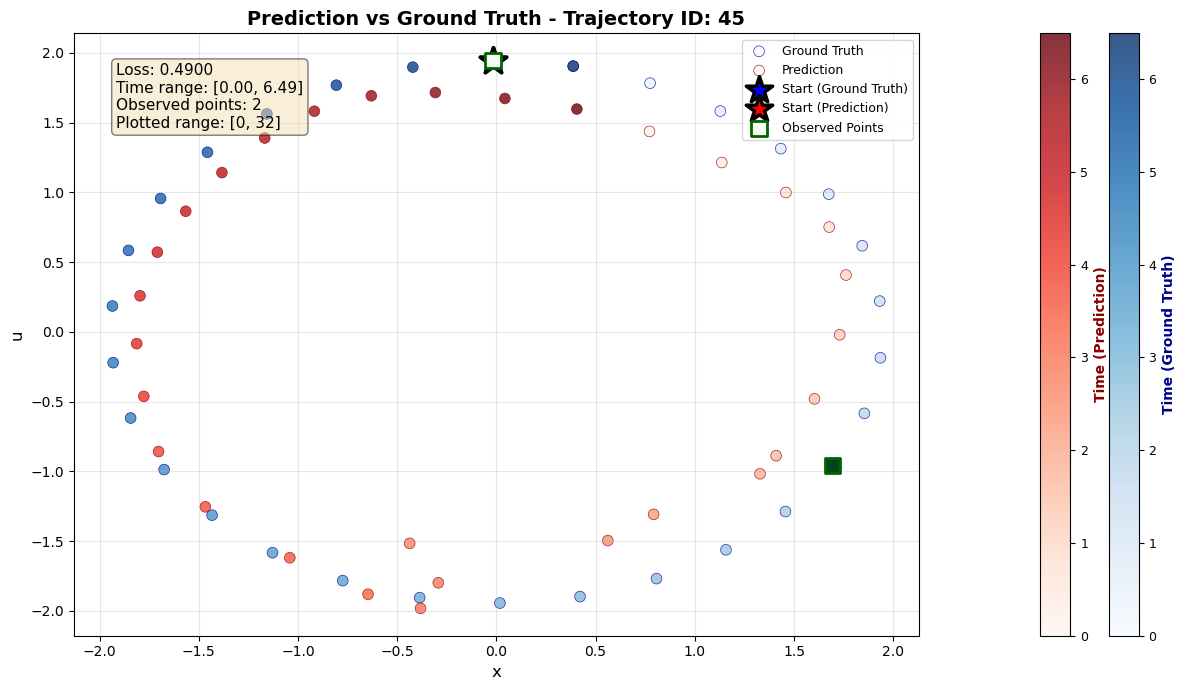

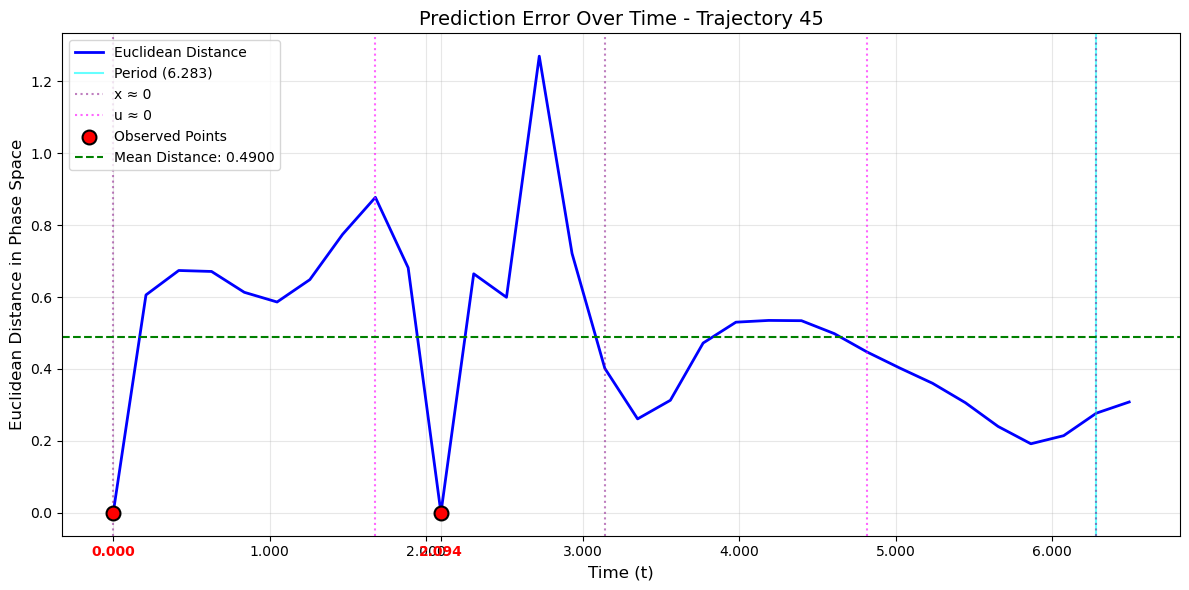

In [16]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, trajectory_id=45, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period)

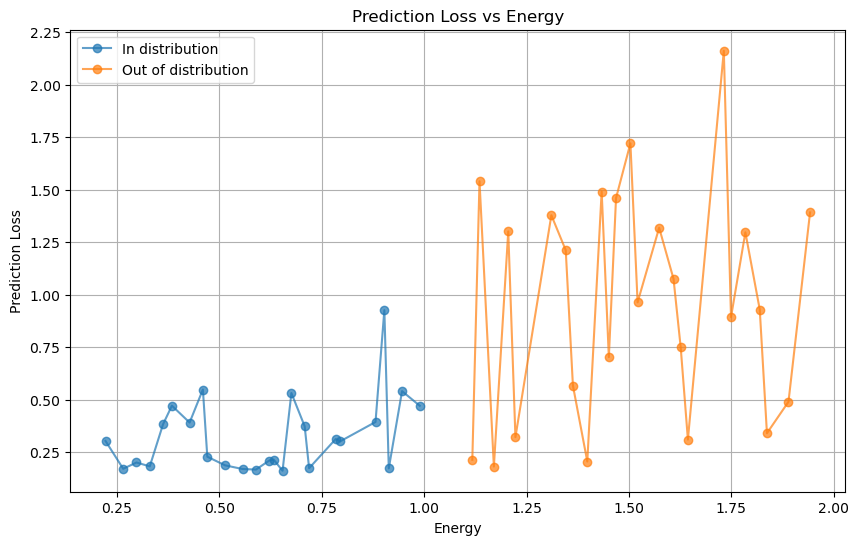

In [40]:
plot_prediction_losses([prediction_test_df, prediction_test_high_energy_df])

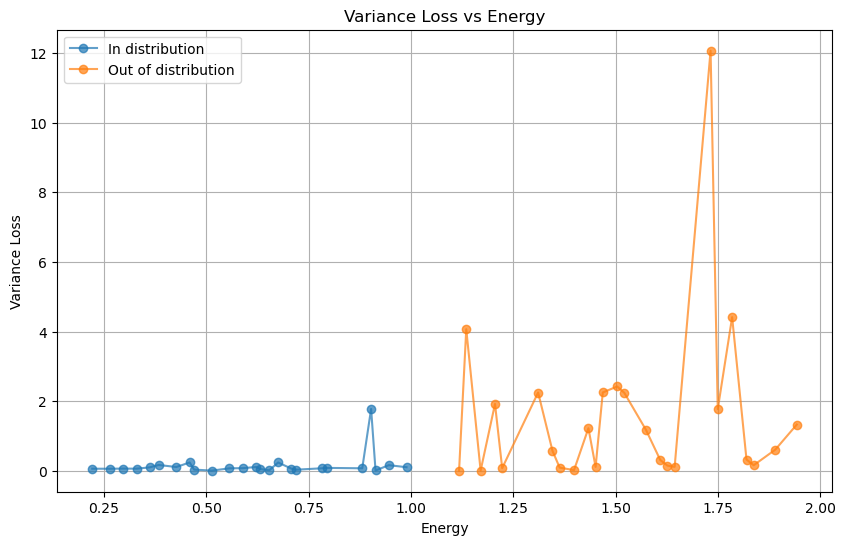

In [41]:
plot_variance_losses([variance_test_df, variance_test_high_energy_df])

Step 1 gamma values mean: 0.580±0.041

Step 2 gamma values mean: 0.611±0.033



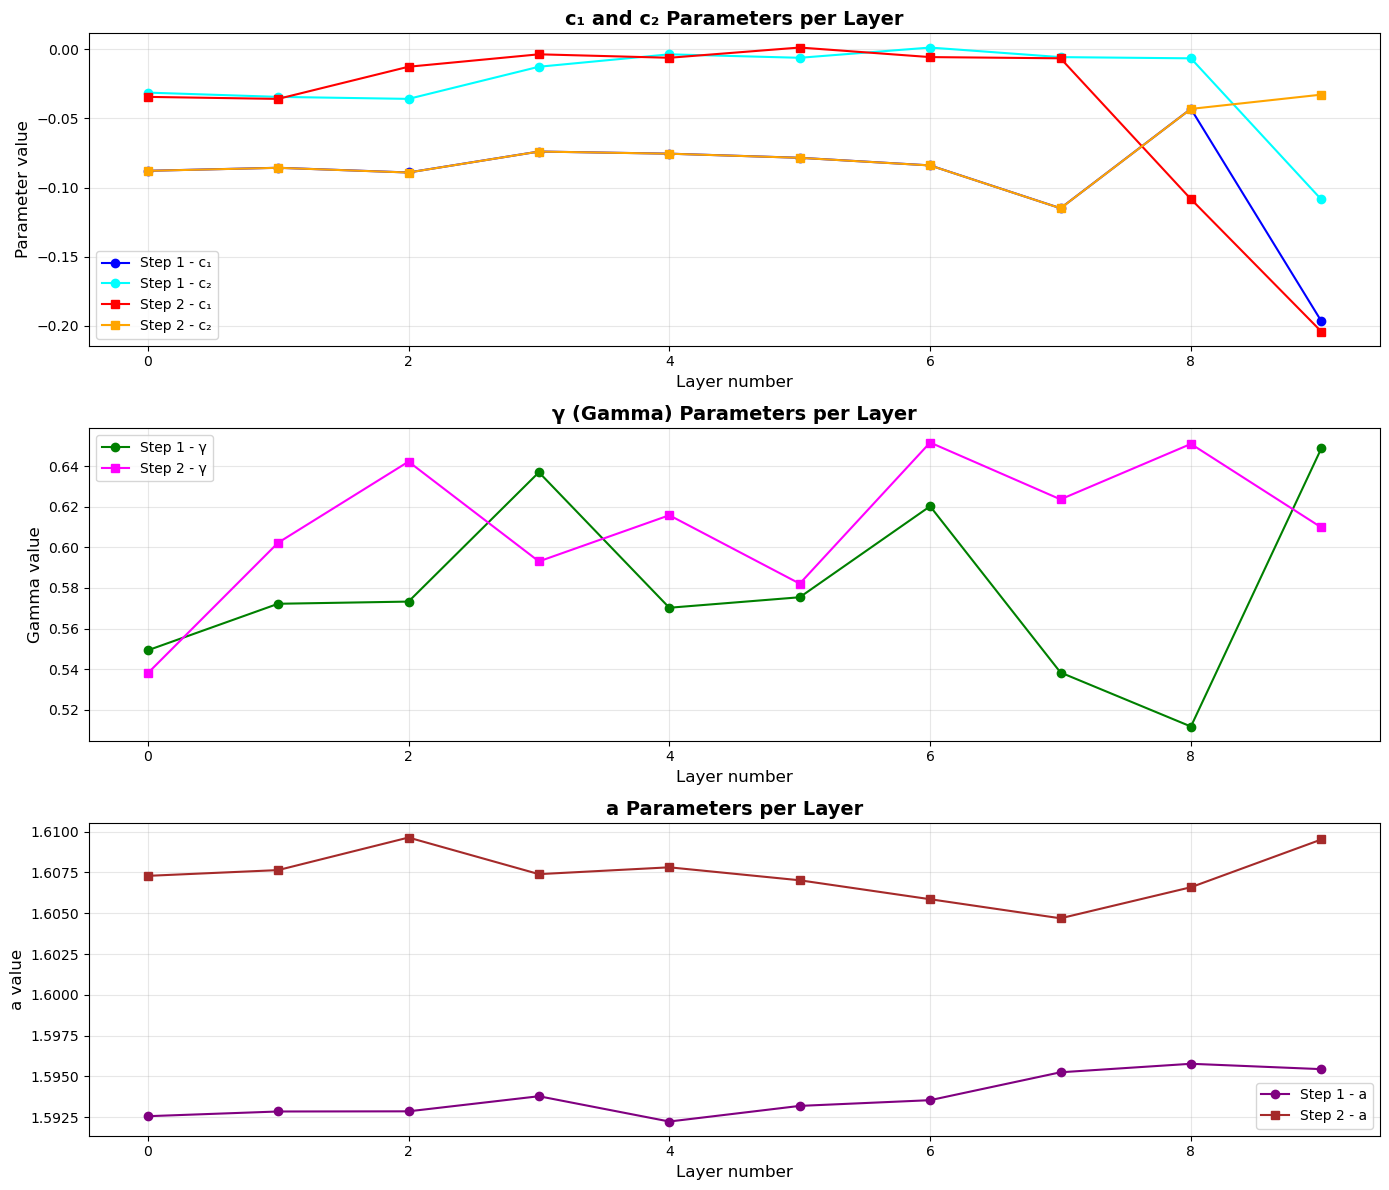

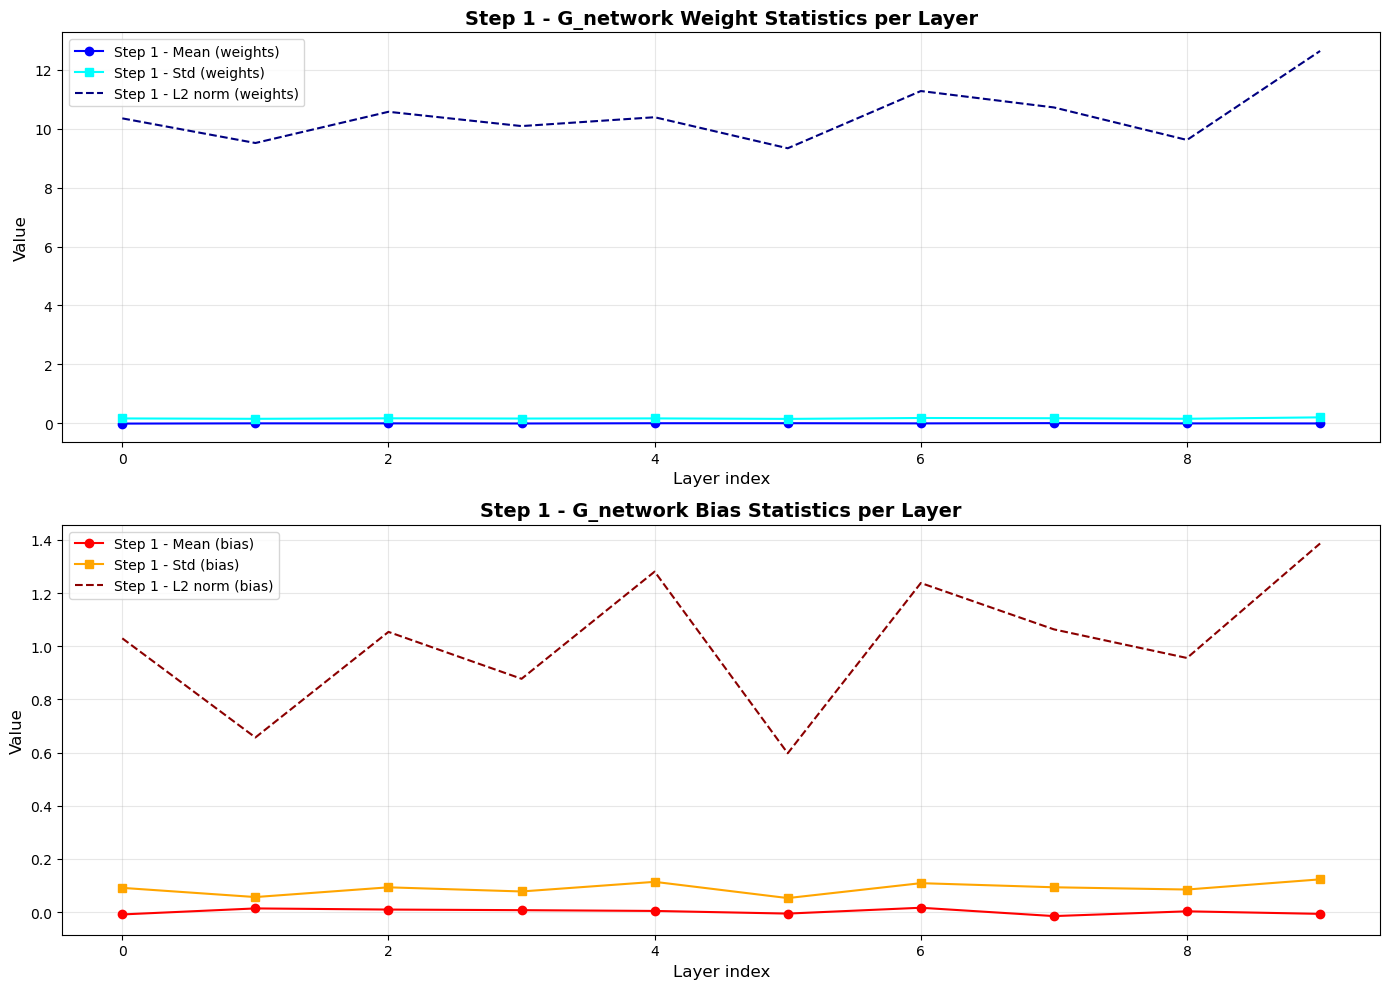

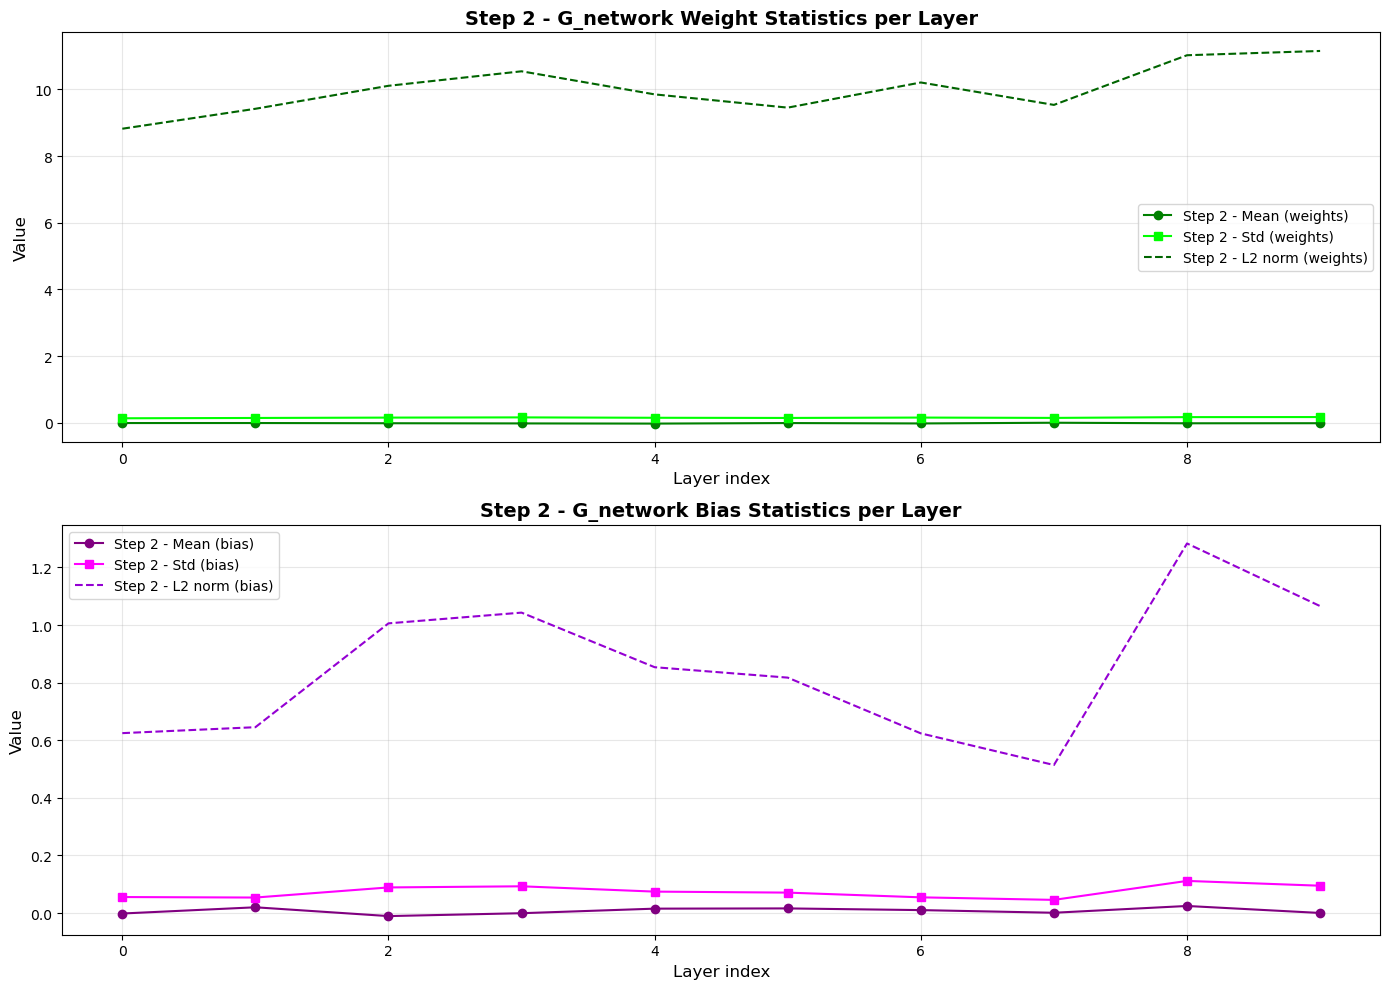

In [189]:
param_data = analyze_mapping_net(mapping_net, return_lists=True)
